In [1]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers


Using TensorFlow backend.


In [2]:
driver_details = pd.read_csv('/home/jupyter/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [3]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [4]:
## Getting all the images

val_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/home/jupyter/TrainImages/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/home/jupyter/TrainImages/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        if driver in driv_selected:
            val_image.append([img,label,driver])
            image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [5]:
## Randomly shuffling the images

import random
random.shuffle(val_image)

In [6]:
## Splitting the train and test

X_test = []
y_test = []
D_test = []
true_test = []

for features,labels,drivers in val_image:
    X_test.append(features)
    y_test.append(labels)
    D_test.append(drivers)
    true_test.append(labels)
    

print (len(X_test),len(y_test))

3692 3692


In [7]:
## Converting images to nparray. Encoding the Y

X_test = np.array(X_test).reshape(-1,224,224,3)
y_test = to_categorical(y_test)


print (X_test.shape)

(3692, 224, 224, 3)


### Exception Model: Extra Layers - Accuracy 82.5% Loss 0.52

In [8]:
## Defining the input

from keras.layers import Input
xception_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception


#Get the RESNET weights and layers

model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

from keras.models import Model


output_xception_conv = model_xception_conv(xception_input)

#Add the fully-connected layers 

x=GlobalAveragePooling2D()(output_xception_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)


xception_pretrained = Model(input = xception_input, output = x)

xception_pretrained = Model(input = xception_input, output = x)
xception_pretrained.load_weights('xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5')



In [9]:
# labels is the image array

from sklearn.metrics import accuracy_score, confusion_matrix

model1_prediction = []
model1_pred_class = []

model1_prediction = xception_pretrained.predict(X_test)
print('Images Predicted until now:',len(model1_prediction))


for i in range(len(model1_prediction)):
    model1_pred_class.append(np.where(model1_prediction[i] == np.amax(model1_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model1_pred_class))
confusion_matrix(true_test,model1_pred_class)



Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8244853737811484


array([[325,   1,   3,   0,   4,  36,   0,   0,   2,  41],
       [  0, 316,   0,   0,   0,   0,  19,   1,   1,   2],
       [  0,   0, 346,   0,   0,   0,   0,   0,   2,   0],
       [  3,   0,   0, 392,   1,   0,   0,   1,   1,   1],
       [  6,   0,   0,   0, 303,   0,   0,   3,  71,  13],
       [  4,   0,   0,   8,   0, 382,   0,   1,   0,   8],
       [  0,   0,   7,   0,   0,   0, 315,  34,  33,   3],
       [  0,   0,   0,   0,   0,   0,   0, 334,   0,   0],
       [  3,   3,  28,   0,   3,   1,  37, 110, 133,  14],
       [ 68,   0,   0,   3,   8,  52,   0,   4,   4, 198]])

In [10]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model1_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.53


### Exception Model: No Extra Layers - Accuracy 82.8% Loss 0.55

In [11]:
## Defining the input

from keras.layers import Input
xception_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception


#Get the RESNET weights and layers

model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

from keras.models import Model


output_xception_conv = model_xception_conv(xception_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_xception_conv)
x = Dense(10, activation='softmax', name='predictions')(x)


xception_pretrained = Model(input = xception_input, output = x)

xception_pretrained = Model(input = xception_input, output = x)
xception_pretrained.load_weights('xception_weights_aug_alltrained_setval_sgd3.hdf5')



In [12]:
# labels is the image array

model2_prediction = []
model2_pred_class = []

model2_prediction = xception_pretrained.predict(X_test)
print('Images Predicted until now:',len(model2_prediction))


for i in range(len(model2_prediction)):
    model2_pred_class.append(np.where(model2_prediction[i] == np.amax(model2_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model2_pred_class))
confusion_matrix(true_test,model2_pred_class)


Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8282773564463706


array([[349,   1,   2,   4,   8,  35,   0,   0,   4,   9],
       [  1, 326,   1,   7,   0,   0,   0,   2,   1,   1],
       [  0,   0, 338,   0,   0,   0,   0,   0,  10,   0],
       [  4,   0,   0, 388,   0,   0,   0,   0,   6,   1],
       [ 16,   0,   4,   0, 286,   0,   0,   0,  69,  21],
       [  9,   0,   0,   1,   0, 381,   0,   0,   7,   5],
       [  0,   0,   3,   0,   0,   0, 340,   1,  44,   4],
       [  0,   0,   1,   0,   2,   0,   0, 301,  30,   0],
       [  9,   1,  16,   0,   2,   4,  29,  83, 183,   5],
       [ 88,   0,   5,   7,  14,  48,   0,   0,   9, 166]])

In [13]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model2_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.55


### RESNET 50 Model: No Extra Layers - Accuracy 85.43% Loss 0.55

In [14]:
## Defining the input
from keras.layers import Input
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')
model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

output_resnet50_conv = model_resnet50_conv(resnet50_input)

x = Flatten(name='flatten')(output_resnet50_conv)
x = Dense(10, activation='softmax', name='predictions')(x)
resnet50_pretrained = Model(input = resnet50_input, output = x)

resnet50_pretrained.load_weights('resnet_weights_aug_alltrained_sgd2_setval.hdf5')

print('Model is Loaded')



Model is Loaded


In [15]:
# labels is the image array


model3_prediction = []
model3_pred_class = []

model3_prediction = resnet50_pretrained.predict(X_test)
print('Images Predicted until now:',len(model3_prediction))


for i in range(len(model3_prediction)):
    model3_pred_class.append(np.where(model3_prediction[i] == np.amax(model3_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model3_pred_class))
confusion_matrix(true_test,model3_pred_class)


Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8542795232936078


array([[386,  10,   0,   0,   3,   6,   0,   0,   0,   7],
       [  2, 301,   0,   3,   0,   2,   0,   1,  23,   7],
       [  0,   0, 333,   0,   0,   0,   1,   0,  14,   0],
       [  4,   1,   0, 390,   3,   0,   0,   0,   1,   0],
       [  5,   0,   0,   0, 307,   0,   0,   1,  83,   0],
       [  8,   0,   0,   0,   3, 390,   0,   0,   0,   2],
       [  2,   0,   0,   0,   0,   0, 333,   7,  50,   0],
       [  2,   0,   1,   0,   0,   0,   0, 294,   6,  31],
       [ 11,   0,  14,   0,   3,   0,  25,  47, 218,  14],
       [ 68,   0,   0,   0,   4,  42,   0,   1,  20, 202]])

In [16]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model3_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.55


### RESNET 50 Model: Extra Layers - Accuracy 86.43% Loss 0.47

In [17]:
## Defining the input

from keras.layers import Input
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model
model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))



output_resnet50_conv = model_resnet50_conv(resnet50_input)
x=GlobalAveragePooling2D()(output_resnet50_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(input = resnet50_input, output = x)

resnet50_pretrained.load_weights('resnet_weights_aug_extralayers_sgd_setval.hdf5')


print('Model is loaded')


Model is loaded


In [18]:
# labels is the image array


model4_prediction = []
model4_pred_class = []

model4_prediction = resnet50_pretrained.predict(X_test)
print('Images Predicted until now:',len(model4_prediction))


for i in range(len(model4_prediction)):
    model4_pred_class.append(np.where(model4_prediction[i] == np.amax(model4_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model4_pred_class))
confusion_matrix(true_test,model4_pred_class)


Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8643011917659805


array([[381,   0,   0,   0,   5,  11,   0,   0,   1,  14],
       [  4, 313,   0,   1,   0,   0,   0,   1,   7,  13],
       [  0,   0, 328,   0,   0,   0,   0,   0,  20,   0],
       [  4,   0,   0, 392,   2,   0,   0,   0,   0,   1],
       [  2,   0,   0,   0, 300,   1,   0,  14,  79,   0],
       [  2,   0,   0,   0,   0, 399,   0,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0, 338,   0,  53,   1],
       [  0,   0,   0,   0,   0,   1,   0, 332,   0,   1],
       [ 14,   0,  25,   0,   2,   5,  18,  90, 177,   1],
       [ 53,   0,   0,   1,   9,  38,   0,   1,   4, 231]])

In [19]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model4_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.48


### VGG 16 Model: No Extra Layers - Accuracy 84.7% Loss 0.5

In [20]:
## Defining the input

from keras.layers import Input
from keras.models import Model


vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')

from keras.applications.vgg16 import VGG16, preprocess_input

model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)



output_vgg16_conv = model_vgg16_conv(vgg16_input)

x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(input = vgg16_input, output = x)


vgg16_pretrained.load_weights('vgg_weights_aug_setval_sgd.hdf5')

print('The Model is loaded')

The Model is loaded


In [21]:
# labels is the image array


model5_prediction = []
model5_pred_class = []

model5_prediction = vgg16_pretrained.predict(X_test)
print('Images Predicted until now:',len(model5_prediction))


for i in range(len(model5_prediction)):
    model5_pred_class.append(np.where(model5_prediction[i] == np.amax(model5_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model5_pred_class))
confusion_matrix(true_test,model5_pred_class)


Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.847237269772481


array([[224,   4,   0,   0,  13, 112,   0,   0,   1,  58],
       [  0, 326,   0,   0,   0,   0,   3,   0,   0,  10],
       [  0,   0, 331,   0,   0,   0,   5,   0,  12,   0],
       [  3,   0,   0, 393,   2,   0,   1,   0,   0,   0],
       [  1,   0,   0,   0, 348,   1,   1,   0,  41,   4],
       [  2,   0,   0,   0,   2, 390,   0,   0,   0,   9],
       [  0,   0,   0,   0,   0,   0, 354,   0,  38,   0],
       [  1,   0,   0,   0,   0,   0,   0, 271,  30,  32],
       [  5,   4,  12,   1,   2,   3,  60,  20, 211,  14],
       [ 29,   2,   0,   1,   8,   7,   1,   1,   8, 280]])

In [22]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model5_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.5


### VGG 16 Model: Extra Layers - Accuracy 81.5% Loss 0.57

In [23]:
## Defining the input

from keras.layers import Input
from keras.models import Model


vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')

from keras.applications.vgg16 import VGG16, preprocess_input

model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)



output_vgg16_conv = model_vgg16_conv(vgg16_input)

x=GlobalAveragePooling2D()(output_vgg16_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(input = vgg16_input, output = x)


vgg16_pretrained.load_weights('vgg_weights_aug_setval_layers_sgd2.hdf5')

print('The Model is loaded')

The Model is loaded


In [24]:
# labels is the image array


model6_prediction = []
model6_pred_class = []

model6_prediction = vgg16_pretrained.predict(X_test)
print('Images Predicted until now:',len(model6_prediction))


for i in range(len(model6_prediction)):
    model6_pred_class.append(np.where(model6_prediction[i] == np.amax(model6_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model6_pred_class))
confusion_matrix(true_test,model6_pred_class)


Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8152762730227519


array([[387,   1,   0,   0,   0,   8,   0,   0,   4,  12],
       [  9, 327,   1,   0,   0,   0,   0,   0,   1,   1],
       [  0,   0, 287,   0,   0,   0,   0,   0,  61,   0],
       [  5,  13,   0, 375,   3,   0,   0,   1,   0,   2],
       [ 13,   0,   0,   0, 242,   0,   0,   0, 138,   3],
       [  5,   0,   0,   0,   0, 392,   0,   0,   5,   1],
       [  2,   0,   2,   0,   5,   0, 234,  10, 136,   3],
       [  0,   0,   0,   0,   0,   0,   0, 315,  15,   4],
       [  1,   4,  20,   0,   0,   8,  19,  66, 210,   4],
       [ 69,   3,   0,   0,   0,   8,   0,   2,  14, 241]])

In [25]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model6_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.57


### Mobilenet Model: Extra Layers - Accuracy 83.6% Loss 0.63

In [26]:
## Defining the input

from keras.layers import Input
from keras.models import Model


mbnet_input = Input(shape = (224, 224, 3), name = 'Image_input')

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input


model_mbnet_conv = MobileNet(weights='imagenet',include_top=False)


x=model_mbnet_conv.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # ****reduce dropout 
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

mbnet_model = Model(inputs=model_mbnet_conv.input, outputs=preds)

mbnet_model.load_weights('mobilenet_weights_1103.hdf5')

print('The Model is loaded')

The Model is loaded


In [27]:
# labels is the image array


model7_prediction = []
model7_pred_class = []

model7_prediction = mbnet_model.predict(X_test)
print('Images Predicted until now:',len(model7_prediction))


for i in range(len(model7_prediction)):
    model7_pred_class.append(np.where(model7_prediction[i] == np.amax(model7_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model7_pred_class))
confusion_matrix(true_test,model7_pred_class)


Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8366738894907909


array([[258,   5,   0,  20,  17,  12,   0,   0,  43,  57],
       [  0, 333,   0,   2,   0,   4,   0,   0,   0,   0],
       [  0,   0, 326,   0,   0,   0,   0,   0,  22,   0],
       [  0,   0,   0, 396,   3,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 318,   0,   0,   0,  78,   0],
       [  2,   0,   0,   0,   0, 398,   0,   0,   3,   0],
       [  0,   0,   6,   0,  13,   0, 283,   0,  90,   0],
       [  0,   6,   0,   0,   0,   2,   0, 306,   5,  15],
       [  1,  15,  19,   0,   0,   0,  11,  30, 251,   5],
       [  3,  16,   0,   8,   1,  35,   0,   1,  53, 220]])

In [28]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model7_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.63


### Mobilenet Model: No Extra Layers - Accuracy 85.7% Loss 0.4

In [29]:
## Defining the input

from keras.layers import Input
from keras.models import Model


mbnet_input = Input(shape = (224, 224, 3), name = 'Image_input')

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input


model_mbnet_conv = MobileNet(weights='imagenet',include_top=False)


x=model_mbnet_conv.output
x=GlobalAveragePooling2D()(x)
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

mbnet_model = Model(inputs=model_mbnet_conv.input, outputs=preds)

mbnet_model.load_weights('mobilenet_sgd_nolayers.hdf5')

print('The Model is loaded')

The Model is loaded


In [30]:
# labels is the image array


model8_prediction = []
model8_pred_class = []

model8_prediction = mbnet_model.predict(X_test)
print('Images Predicted until now:',len(model8_prediction))


for i in range(len(model8_prediction)):
    model8_pred_class.append(np.where(model8_prediction[i] == np.amax(model8_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model8_pred_class))
confusion_matrix(true_test,model8_pred_class)


Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8572589382448538


array([[322,   1,   0,  13,   2,   9,   0,   0,  11,  54],
       [  9, 302,   0,   2,   0,   1,   0,   3,   4,  18],
       [  0,   0, 339,   0,   0,   0,   0,   0,   9,   0],
       [  0,   0,   0, 393,   0,   0,   0,   0,   6,   0],
       [  5,   0,   0,   0, 306,   0,   0,   1,  82,   2],
       [  2,   0,   0,   8,   0, 393,   0,   0,   0,   0],
       [ 14,   0,  10,   0,   0,   0, 311,   0,  57,   0],
       [  0,   0,   0,   0,   0,   1,   0, 333,   0,   0],
       [  8,   0,  27,   0,   0,  14,  16,  66, 198,   3],
       [ 28,   0,   0,   8,   6,   2,   0,   2,  23, 268]])

In [31]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model8_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.4


### Ensembling

In [150]:
from statistics import mean,median


ensemble_predictions = []
predictions = []

for i in range(len(X_test)):
#for i in range(1):
    mean_prediction = []
    
    for j in range(len(y_test[0])):
        predictions.append(model1_prediction[i][j])
        predictions.append(model2_prediction[i][j])
        predictions.append(model3_prediction[i][j])
        predictions.append(model4_prediction[i][j])
        predictions.append(model5_prediction[i][j])
        predictions.append(model6_prediction[i][j])
        #predictions.append(model7_prediction[i][j])
        predictions.append(model8_prediction[i][j])
        
        #print(predictions)
        
        trimmed_value = (sum(predictions) - max(predictions) - min(predictions))/(len(predictions) - 2)
        
        mean_value = mean(predictions)

        predictions = []
        mean_prediction.append(trimmed_value)
    
    mean_prediction = mean_prediction/ sum(mean_prediction)
    ensemble_predictions.append(mean_prediction)
        
    
ensemble_predictions = np.asarray(ensemble_predictions)        
    
    

In [151]:
ensemble_class = []

for i in range(len(ensemble_predictions)):
    ensemble_class.append(np.where(ensemble_predictions[i] == np.amax(ensemble_predictions[i]))[0][0])


In [152]:
print('The accuracy of this model over validation set is:',accuracy_score(true_test,ensemble_class))

The accuracy of this model over validation set is: 0.8962621885157096


In [153]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, ensemble_predictions, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.3


### KNN on the Validation Images

In [118]:
## Defining the input

from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
#model_vgg16_conv.summary()
print('Model Loaded')

Model Loaded


In [119]:
vgg16_features_output=model_vgg16_conv.predict(X_test)
vgg16_features_output.shape

(3692, 7, 7, 512)

In [120]:
knn_input=np.reshape(vgg16_features_output,(3692,-1))

In [121]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10).fit(knn_input)
print("Done")

Done


In [122]:
distances, indices = nbrs.kneighbors(knn_input)

In [123]:
indices[0]

array([   0, 1563, 1465, 2728,  379, 1338,  169, 1422,  403, 1287])

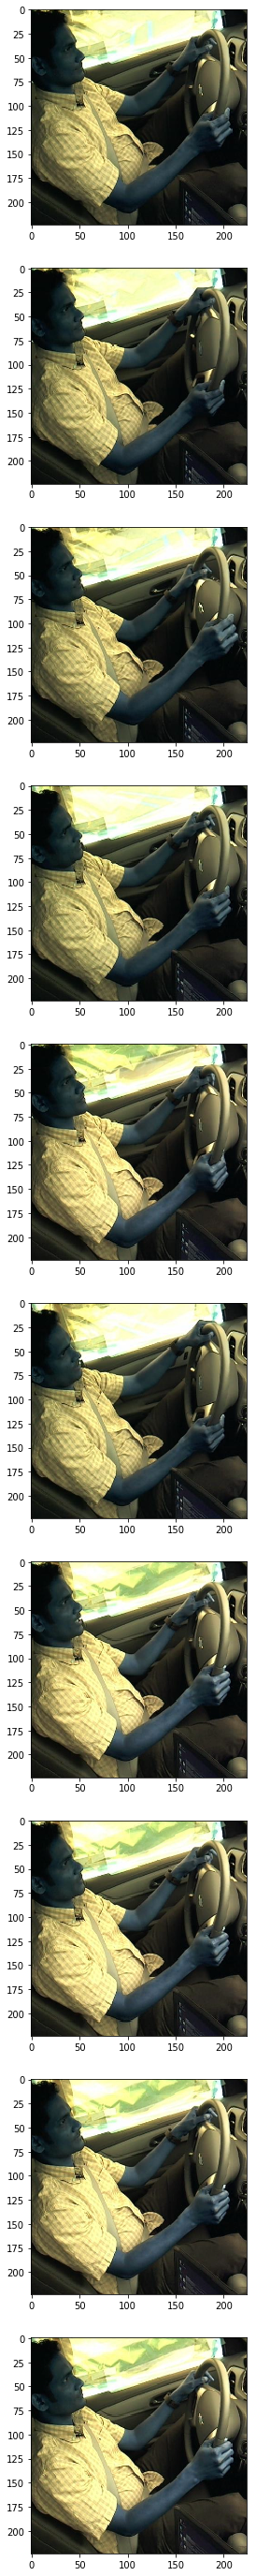

In [124]:
fig, ax = plt.subplots(10, 1, figsize = (50,50))

img = 0

for i in indices[0]:  
    ax[img].imshow(X_test[i])
    plt.show
    img = img+1
    

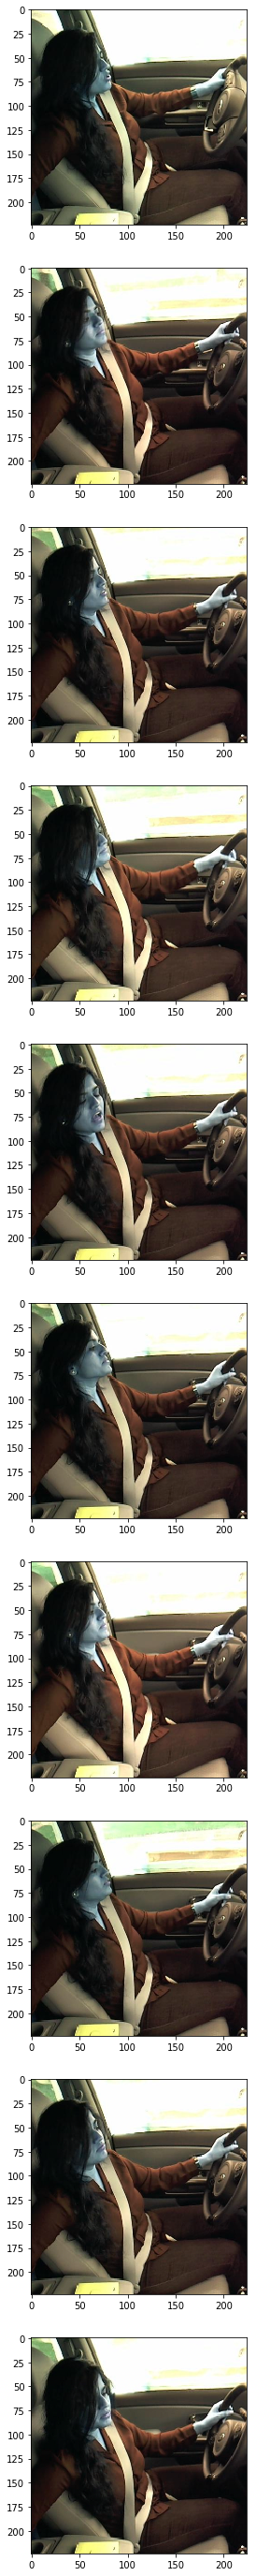

In [125]:
fig, ax = plt.subplots(10, 1, figsize = (50,50))

img = 0

for i in indices[10]:  
    ax[img].imshow(X_test[i])
    plt.show
    img = img+1
    

In [142]:
knn_predictions = []
predictions = []

for i in range(indices.shape[0]):
    mean_prediction = []
    for j in range(len(y_test[0])):
        for img in indices[i]:
            predictions.append(ensemble_predictions[img][j])
        
        trimmed_value = (sum(predictions) - max(predictions) - min(predictions))/(len(predictions) -2 )
        mean_value = mean(predictions)
        predictions = []
    
        mean_prediction.append(trimmed_value)
    
    mean_prediction = mean_prediction/sum(mean_prediction)
    knn_predictions.append(mean_prediction)
            
knn_predictions = np.asarray(knn_predictions)           
        

        
print('The code is done')
    

The code is done


In [143]:
knn_class = []

for i in range(len(knn_predictions)):
    knn_class.append(np.where(knn_predictions[i] == np.amax(knn_predictions[i]))[0][0])


In [144]:
print('The accuracy of this model over validation set is:',accuracy_score(true_test,knn_class))

The accuracy of this model over validation set is: 0.9219934994582882


In [145]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, knn_predictions, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.24
